In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.aparent_all_libs import load_saved_predictor


Using TensorFlow backend.


<h2>Define Isoform Loss Function and SeqProp Wrapper</h2>

- Define an isoform loss function generator, optimizing for a target isoform proportion.<br/>
- Build a SeqProp wrapper that builds the generator and predictor, and executs the optimization.<br/>
- Use the continuous PWM (Softmax sequence distribution) as predictor input


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    use_entropy_mse = get_margin_entropy(pwm_start=use_start, pwm_end=use_end, min_bits=use_target_bits)
    cse_entropy_mse = get_margin_entropy(pwm_start=cse_start, pwm_end=cse_end, min_bits=cse_target_bits)
    dse_entropy_mse = get_margin_entropy(pwm_start=dse_start, pwm_end=dse_end, min_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_pred_score, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance from cut distribution
        #iso_pred_score = K.expand_dims(K.sum(cut_score_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Specify costs
        iso_loss = -1.0 * K.mean(iso_pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_pred_score, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance from cut distribution
        #iso_pred_score = K.expand_dims(K.sum(cut_score_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Specify costs
        iso_loss = -1.0 * K.mean(iso_pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        
        self.val_loss_history.append(val_loss_value)
        
        #print("mean(" + self.val_name + ") = " + str(np.mean(val_loss_values)))

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, library_context='simple', eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100, lr=1.0) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        _, valid_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if 'aparent' in layer.name and '_valversion' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        opt = keras.optimizers.SGD(lr=lr)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        #opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        
        #train_monitor = FlexibleSeqPropCutMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Isoform Log Odds', plot_pwm_start=70-50, plot_pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.25))
        valid_monitor = FlexibleSeqPropCutMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Isoform Log Odds', plot_pwm_start=70-50, plot_pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.25))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [3]:
#Specfiy file path to pre-trained predictor network
'''
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)
'''
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)


<h2>Run SeqProp to Optimize Target Isoforms (Alien1 Library)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Hard-code Alien1 UTR template into sequence.<br/>
- Auxiliary objectives: Punish upstream C, slightly punish G, punish poly-A runs.<br/>


In [4]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'Alien1 Max Isoform'
Optimizing objective 0...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
10000/10000 [==============================] - 140s 14ms/step - loss: -11.8701


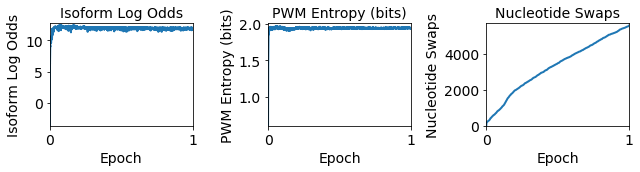

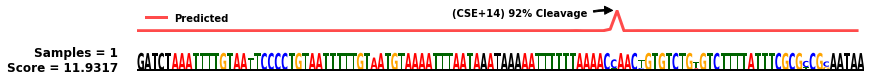

In [6]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
library_context = 'simple'

iso_objectives = [1.0]

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'Alien1 Max Isoform'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 10000
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = True
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64
#SGD learning rate
lr = 0.1

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses, val_losses = zip(*[
    get_isoform_loss(
        target_iso,
        use_start=22,
        use_end=70,
        use_target_bits=1.95,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.95,
        dse_start=76,
        dse_end=121,
        dse_target_bits=1.95,
        entropy_weight=0.0,
        punish_dn_cse=1.0,
        punish_up_c=0.0015,
        punish_dn_c=0.0001,
        punish_up_g=0.0001,
        punish_dn_g=0.0001,
        punish_up_aa=0.00025,
        punish_dn_aa=0.005
    )
    for target_iso in iso_objectives
])

transforms = [
    None#get_nop_transform()
    for target_iso in iso_objectives
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, library_context, eval_mode, normalize_logits, n_epochs, steps_per_epoch, lr)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


Running optimization experiment 'Alien1 Max Isoform'
Experiment name = Sampled (LR = 0.1)
Eval mode = sample
Normalize logits = True
Optimizing objective 0...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
10000/10000 [==============================] - 209s 21ms/step - loss: -89.7244


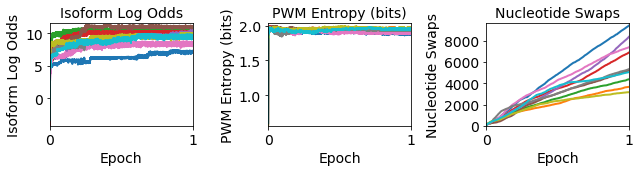

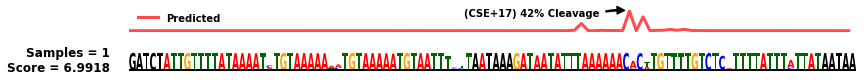

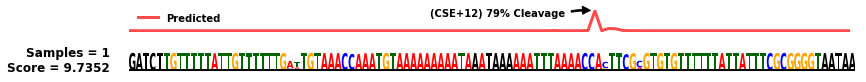

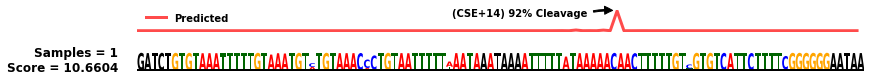

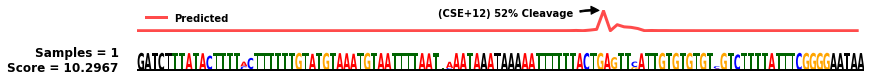

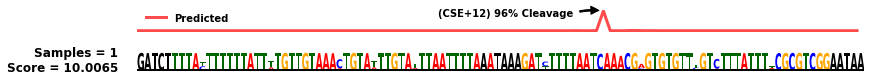

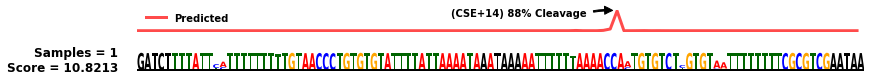

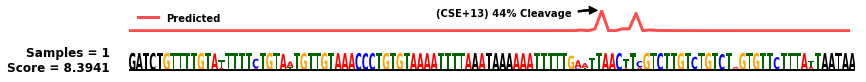

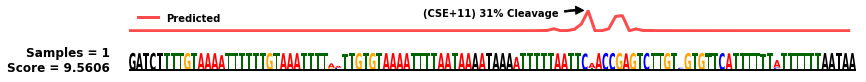

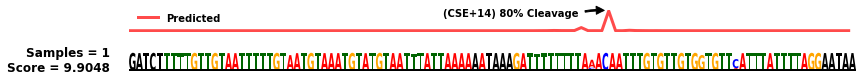

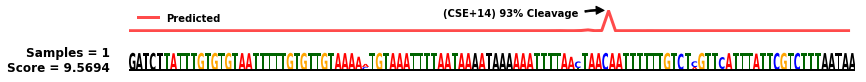

Experiment name = PWM (LR = 0.1)
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
10000/10000 [==============================] - 213s 21ms/step - loss: -1.3212


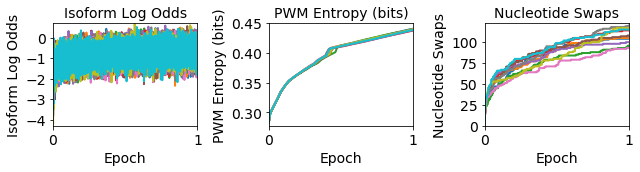

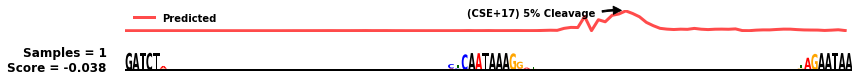

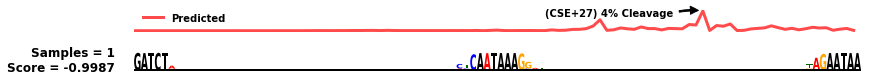

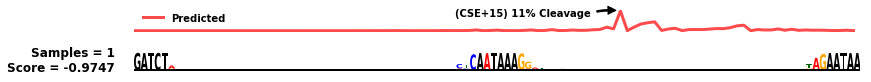

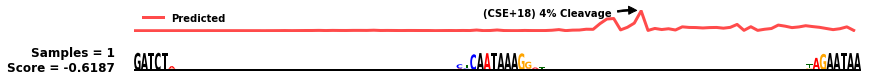

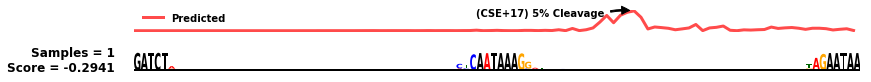

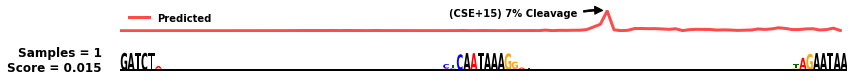

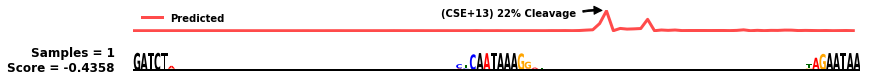

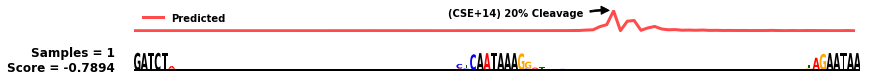

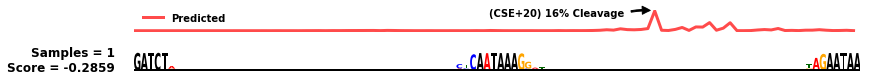

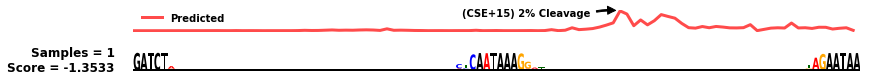

Experiment name = PWM (LR = 1.0)
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
10000/10000 [==============================] - 212s 21ms/step - loss: -3.8870


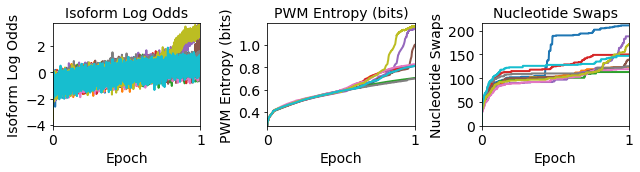

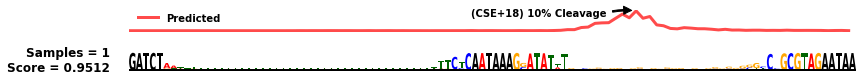

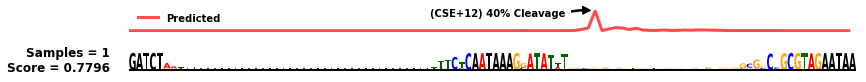

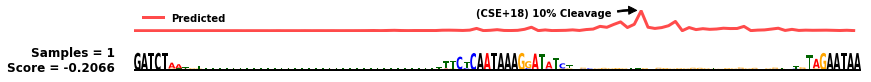

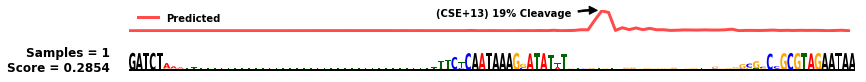

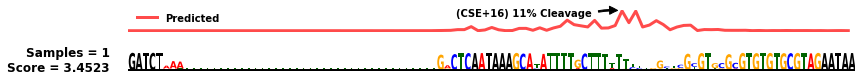

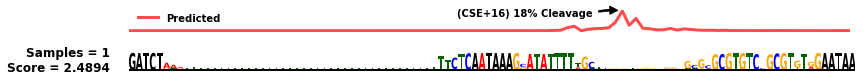

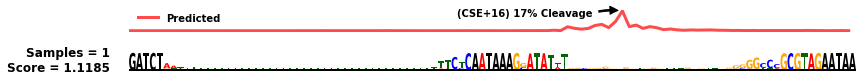

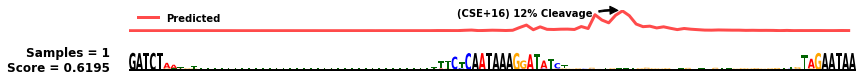

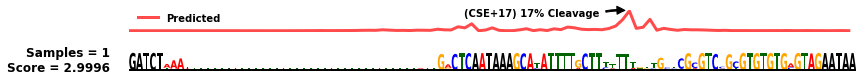

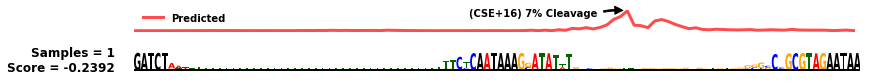

Experiment name = PWM (LR = 5.0)
Eval mode = pwm
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
10000/10000 [==============================] - 212s 21ms/step - loss: -71.1287


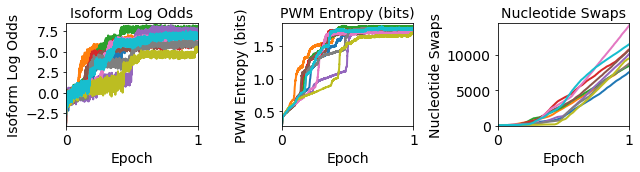

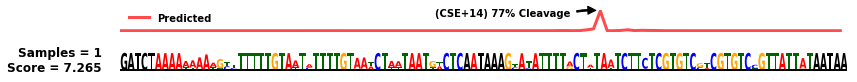

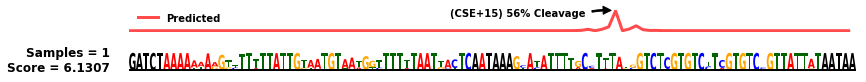

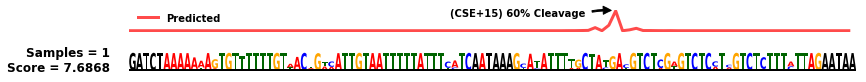

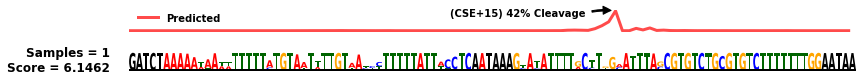

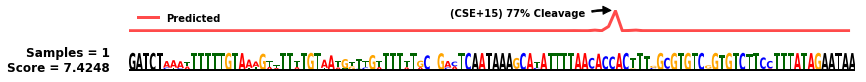

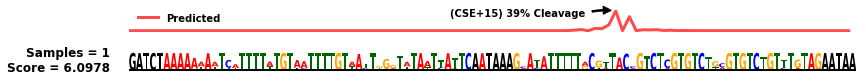

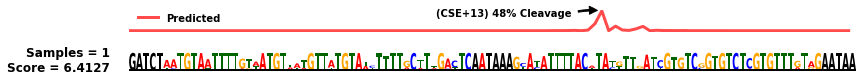

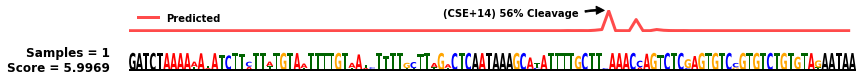

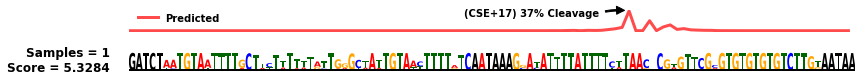

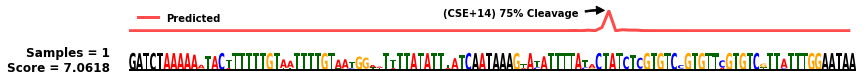

In [7]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
library_context = 'simple'

iso_objectives = [1.0]

rand_seed = 14755

#Run SeqProp Optimization

print("Running optimization experiment 'Alien1 Max Isoform'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 10000
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 10

experiment_id_list = ['sample_lr_01', 'pwm_lr_01', 'pwm_lr_10', 'pwm_lr_50']
experiment_name_list = ['Sampled (LR = 0.1)', 'PWM (LR = 0.1)', 'PWM (LR = 1.0)', 'PWM (LR = 5.0)']
eval_mode_list = ['sample', 'pwm', 'pwm', 'pwm']
normalize_logits_list = [True, False, False, False]
lr_list = [0.1, 0.1, 1.0, 5.0]

result_dict = {
    'sample_lr_01' : {},
    'pwm_lr_01' : {},
    'pwm_lr_10' : {},
    'pwm_lr_50' : {}
}

for experiment_id, experiment_name, eval_mode, normalize_logits, lr in zip(experiment_id_list, experiment_name_list, eval_mode_list, normalize_logits_list, lr_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)

    sequence_templates = [
        seq_template
        for target_iso in iso_objectives
    ]

    losses, val_losses = zip(*[
        get_isoform_loss(
            target_iso,
            use_start=22,
            use_end=70,
            use_target_bits=1.95,
            cse_start=70,
            cse_end=76,
            cse_target_bits=1.95,
            dse_start=76,
            dse_end=121,
            dse_target_bits=1.95,
            entropy_weight=0.0,#1.0,
            punish_dn_cse=1.0,
            punish_up_c=0.0015,
            punish_dn_c=0.0001,
            punish_up_g=0.0001,
            punish_dn_g=0.0001,
            punish_up_aa=0.00025,
            punish_dn_aa=0.005
        )
        for target_iso in iso_objectives
    ])

    transforms = [
        None#get_nop_transform()
        for target_iso in iso_objectives
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, library_context, eval_mode, normalize_logits, n_epochs, steps_per_epoch, lr)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    result_dict[experiment_id] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
    }


Experiment name = Sampled (LR = 0.1)


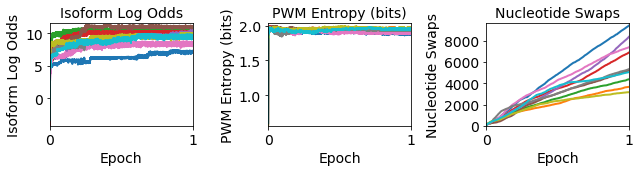

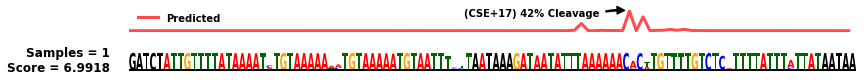

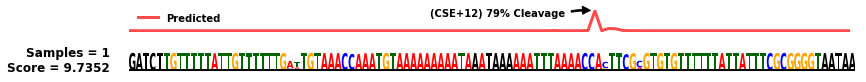

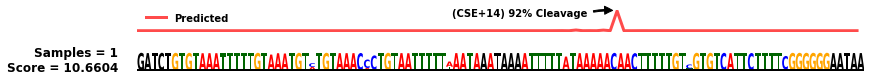

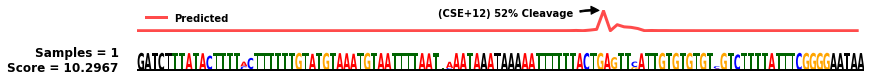

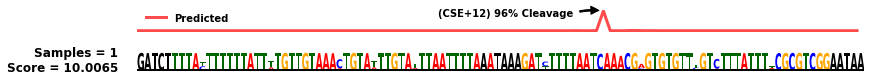

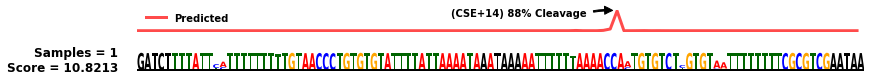

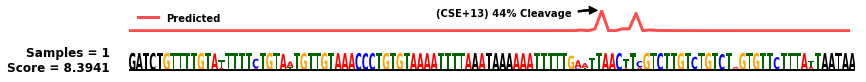

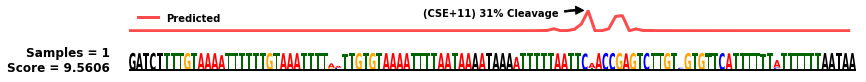

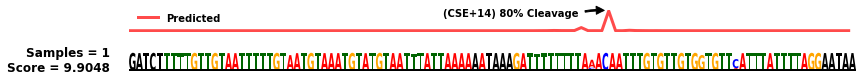

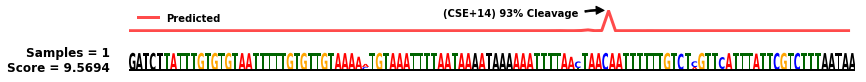

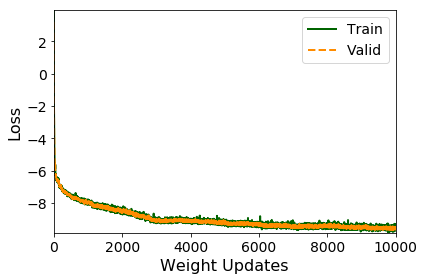

Experiment name = PWM (LR = 0.1)


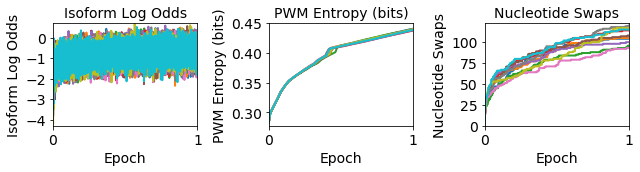

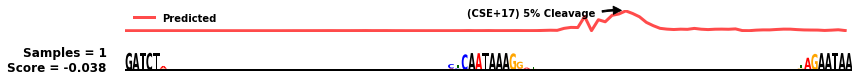

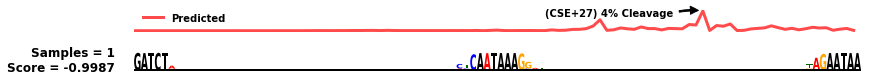

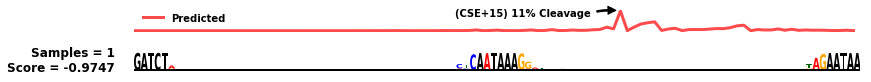

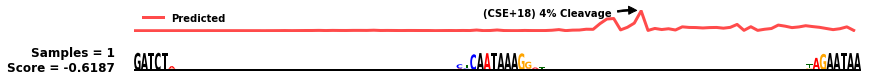

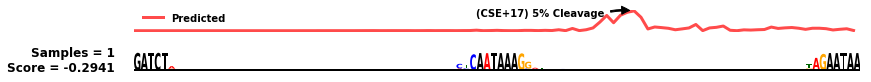

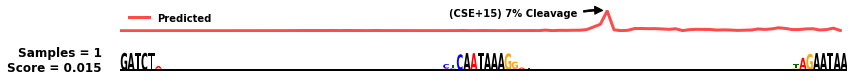

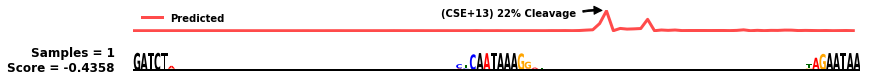

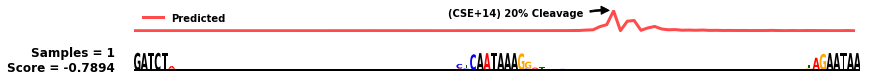

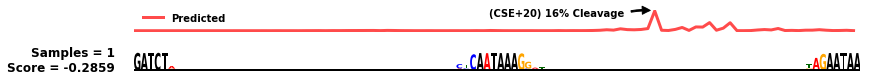

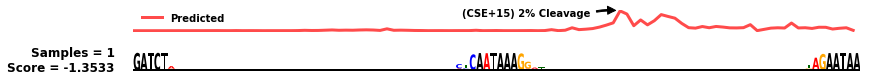

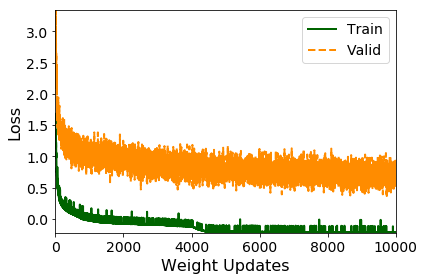

Experiment name = PWM (LR = 1.0)


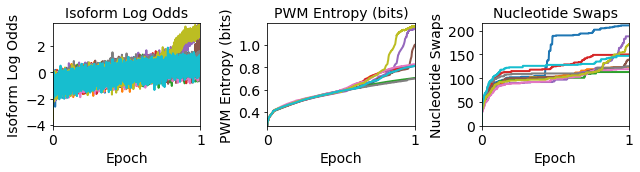

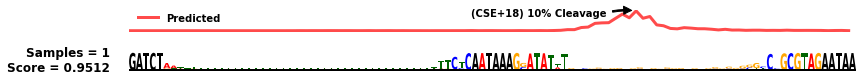

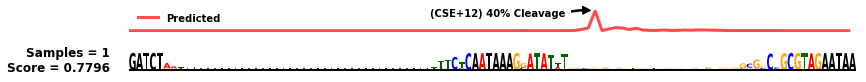

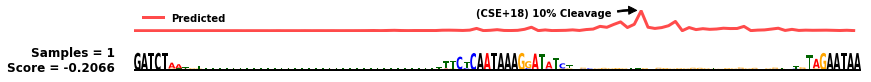

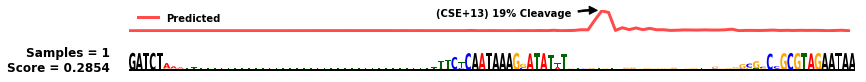

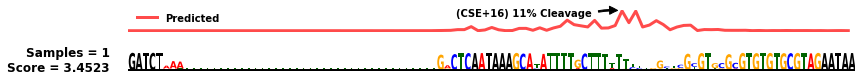

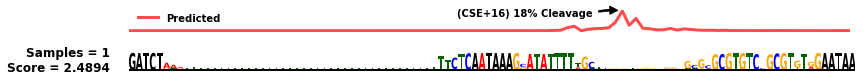

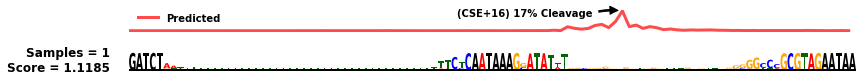

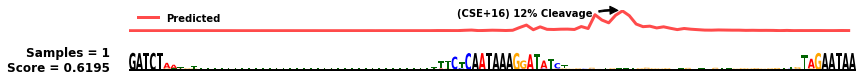

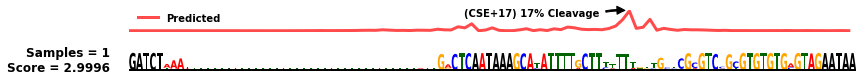

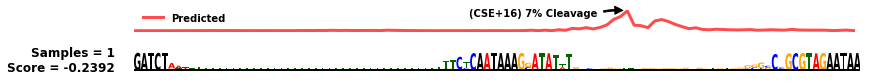

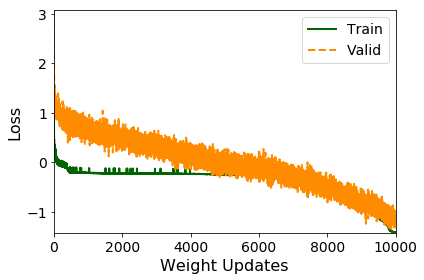

Experiment name = PWM (LR = 5.0)


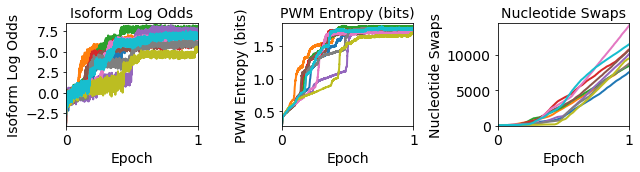

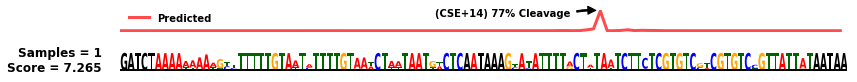

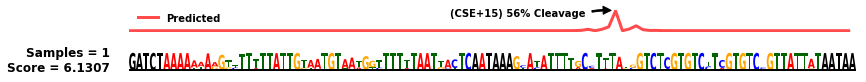

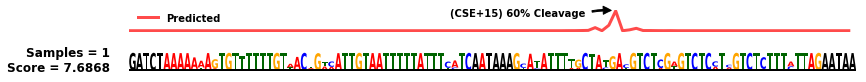

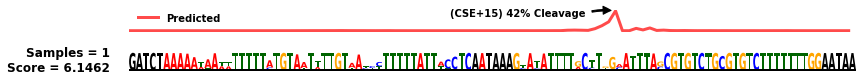

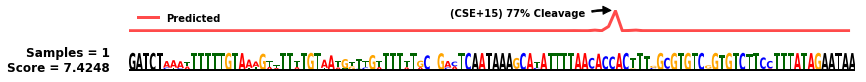

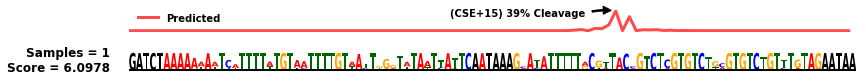

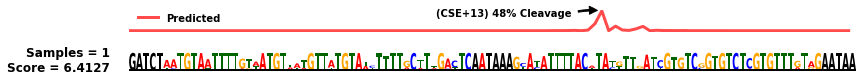

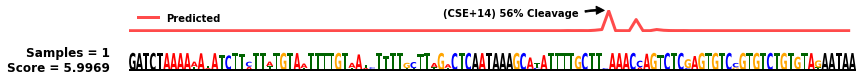

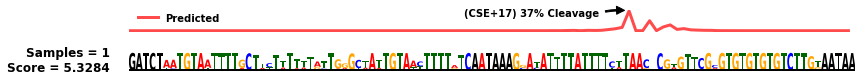

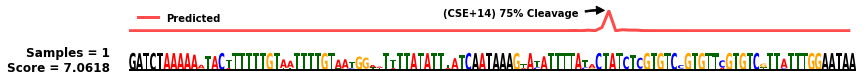

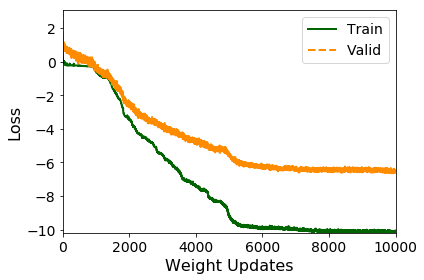

--- Comparison of loss convergence ---


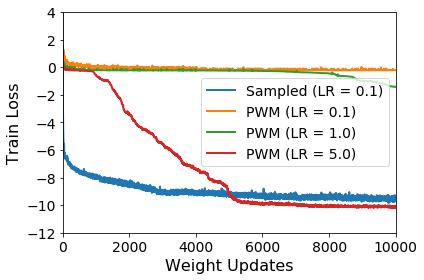

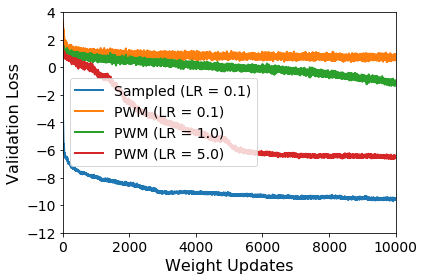

--- Comparison of log odds convergence ---


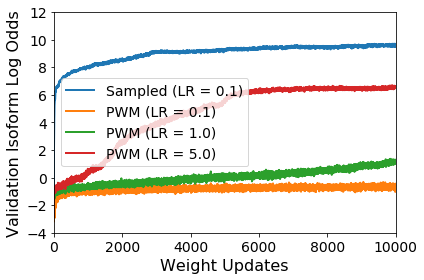

In [8]:

save_figs = True
fig_prefix = "eval_seqprop_max_iso_simple_pwm_vs_sample_instancenorm_sgd_lr_earthmover_experiment_10000_updates_"

for experiment_ix, experiment_id in enumerate(experiment_id_list) :
    
    experiment_name = experiment_name_list[experiment_ix]
    
    print("Experiment name = " + str(experiment_name))

    seqprop_predictor = result_dict[experiment_id]['seqprop_predictor']
    valid_monitor = result_dict[experiment_id]['valid_monitor']
    train_history = result_dict[experiment_id]['train_history']
    valid_history = result_dict[experiment_id]['valid_history']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_id + "_" if save_figs else None

    valid_monitor.plot_metrics_and_pwm(fig_name=fig_name)

    f = plt.figure(figsize=(6, 4))

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
    l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min(np.min(train_history.val_loss_history) / n_sequences, np.min(valid_history.val_loss_history)), max(np.max(train_history.val_loss_history) / n_sequences, np.max(valid_history.val_loss_history)))

    plt.legend(handles=[l1[0], l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -12.
    max_y_val = 4.

    for experiment_ix, experiment_id in enumerate(experiment_id_list) :
        
        experiment_name = experiment_name_list[experiment_ix]
        curr_history = result_dict[experiment_id][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of log odds convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -4.
max_y_val = 12.

for experiment_ix, experiment_id in enumerate(experiment_id_list) :
    
    experiment_name = experiment_name_list[experiment_ix]
    curr_monitor = result_dict[experiment_id]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation Isoform Log Odds", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()
